In [10]:
import os
import time
import copy
import glob
import cv2
import shutil

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
# 이미지 데이터 전처리 방법 정의

data_path = 'data/catanddog/train'

trsf = transforms.Compose(
    [
        transforms.Resize([256, 256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)
# torchvision.transforms -> 이미지 데이터를 변환하여 모델의 입력으로 사용할 수 있게 변환
# Resize : 이미지의 크기를 재조정
# RandomResizedCrop : 랜덤한 크기 및 비율로 자름
# RandomHorizontalFlip : 이미지를 랜덤하게 수평으로 뒤집음
# ToTensor : 이미지 데이터를 텐서로 변환

train_dataset = torchvision.datasets.ImageFolder(
    data_path, transform= trsf
)
# ImageFolder -> 데이터로더가 데이터를 불러올 경로와 방법

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size= 32,
    num_workers= 8,
    shuffle= True
)

print(len(train_dataset))

385


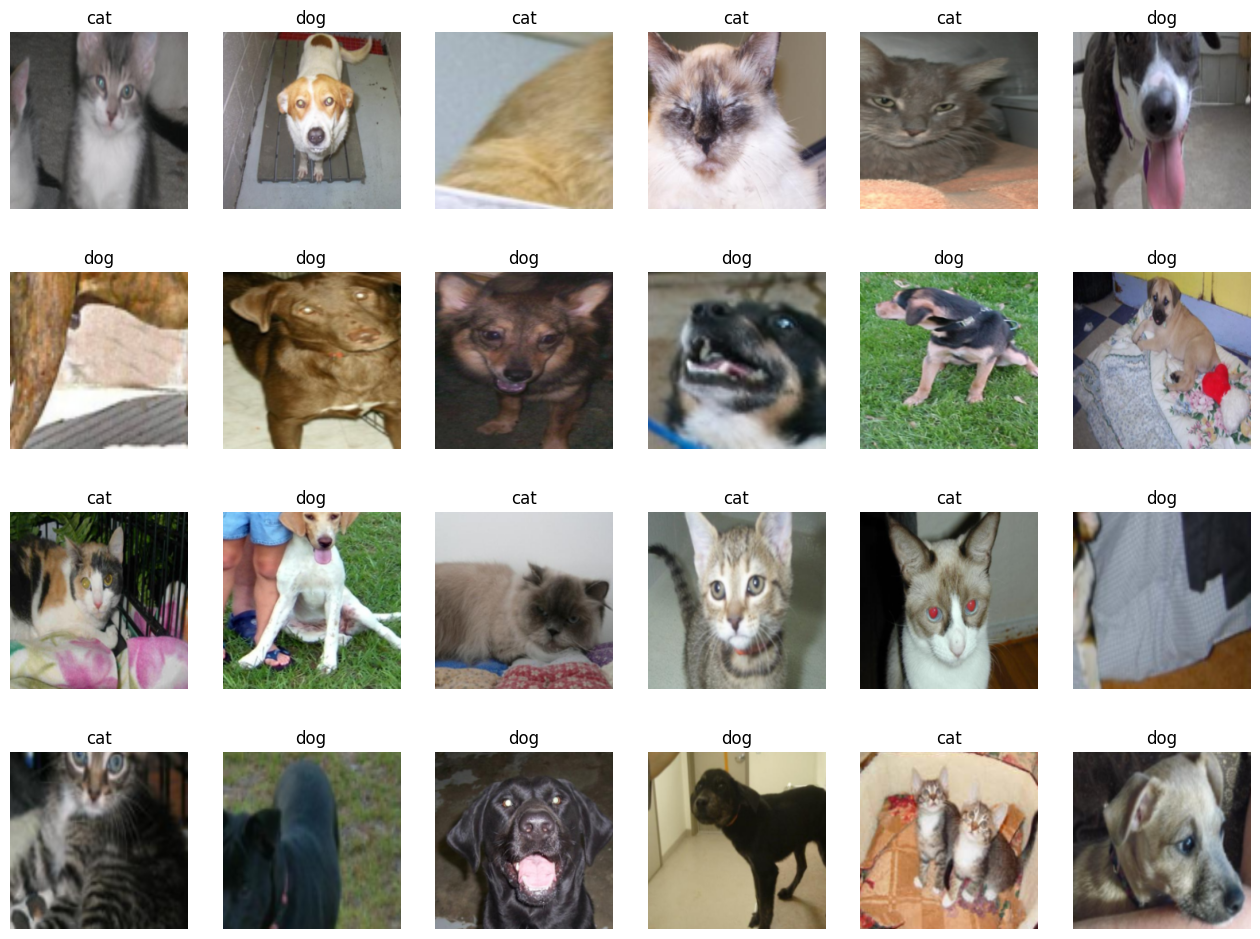

In [3]:
# 학습에 사용될 이미지 출력

samples, labels = next(iter(train_loader))
classes = {0 : 'cat', 1 : 'dog'}
fig = plt.figure(figsize= (16,24))

for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))

plt.subplots_adjust(bottom= 0.2, top= 0.6, hspace= 0)

In [4]:
# 사전 훈련된 모델
resnet18 = models.resnet18(pretrained= True)

# 파라미터 학습 유무 지정
def set_parameter_requires_grad(model, feature_extracting= True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

# 완전연결층 추가
resnet18.fc = nn.Linear(512, 2)

# 파라미터 값 확인
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

c:\Users\Ino\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ino\anaconda3\envs\torch_book\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


fc.weight tensor([[ 0.0053,  0.0270, -0.0373,  ...,  0.0037,  0.0002, -0.0285],
        [-0.0052,  0.0042,  0.0225,  ...,  0.0224,  0.0245, -0.0131]])
fc.bias tensor([-0.0434,  0.0141])


In [5]:
# 모델 객체 생성, 손실 함수 정의

model = models.resnet18(pretrained= True)

for param in model.parameters(): # 합성곱층 가중치 고정
    param.required_grad = False

model.fc = torch.nn.Linear(512,2)
for param in model.fc.parameters(): # 완전연결층은 학습
    param.requires_grad = True

opt = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# 모델 학습 함수

def train_model(model, dataloaders, criterion, optmizer, device, num_epochs= 13, is_train= True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            opt.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            opt.step()

            running_loss += loss.item()*inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('data/catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history, loss_history

In [7]:
# 학습 결과를 옵티마이저에 전달

params_to_update = []

for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print('\t', name)

opt = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, opt, device)

Epoch 0/12
----------


Loss: 0.6384 Acc: 0.6260

Epoch 1/12
----------
Loss: 0.3687 Acc: 0.8727

Epoch 2/12
----------
Loss: 0.3083 Acc: 0.8883

Epoch 3/12
----------
Loss: 0.3277 Acc: 0.8442

Epoch 4/12
----------
Loss: 0.3322 Acc: 0.8442

Epoch 5/12
----------
Loss: 0.3196 Acc: 0.8519

Epoch 6/12
----------
Loss: 0.2846 Acc: 0.8649

Epoch 7/12
----------
Loss: 0.2583 Acc: 0.8727

Epoch 8/12
----------
Loss: 0.1995 Acc: 0.9221

Epoch 9/12
----------
Loss: 0.2166 Acc: 0.9247

Epoch 10/12
----------
Loss: 0.2256 Acc: 0.8987

Epoch 11/12
----------
Loss: 0.1966 Acc: 0.9143

Epoch 12/12
----------
Loss: 0.2326 Acc: 0.8909

Training complete in 5.000000m 11.271077s
Best Acc: 0.924675


In [13]:
# 테스트 데이터 호출, 전처리

test_path = 'data/catanddog/test'

trsf = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

test_dataset = torchvision.datasets.ImageFolder(
    root= test_path,
    transform= trsf
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size= 32,
    num_workers= 1,
    shuffle= True
)

print(len(test_dataset))

98


In [33]:
# 테스트 데이터 평가 함수

def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('data/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels.cpu()).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print(f'Acc: {epoch_acc}')

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print(f'Val complete in {time_elapsed // 60}m {time_elapsed * 60}s')
    print(f'Best Acc: {best_acc}')

    return acc_history

In [34]:
# 평가
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['data/catanddog\\00.pth', 'data/catanddog\\01.pth', 'data/catanddog\\02.pth', 'data/catanddog\\03.pth', 'data/catanddog\\04.pth', 'data/catanddog\\05.pth', 'data/catanddog\\06.pth', 'data/catanddog\\07.pth', 'data/catanddog\\08.pth', 'data/catanddog\\09.pth', 'data/catanddog\\10.pth', 'data/catanddog\\11.pth', 'data/catanddog\\12.pth']
Loading model data/catanddog\00.pth
Acc: 0.8367346938775511

Loading model data/catanddog\01.pth
Acc: 0.8877551020408163

Loading model data/catanddog\02.pth
Acc: 0.8979591836734694

Loading model data/catanddog\03.pth
Acc: 0.9081632653061225

Loading model data/catanddog\04.pth
Acc: 0.8979591836734694

Loading model data/catanddog\05.pth
Acc: 0.9081632653061225

Loading model data/catanddog\06.pth
Acc: 0.9081632653061225

Loading model data/catanddog\07.pth
Acc: 0.9489795918367347

Loading model data/catanddog\08.pth
Acc: 0.9183673469387755

Loading model data/catanddog\09.pth
Acc: 0.9285714285714286

Loading model data/catanddog\10.pth
Acc

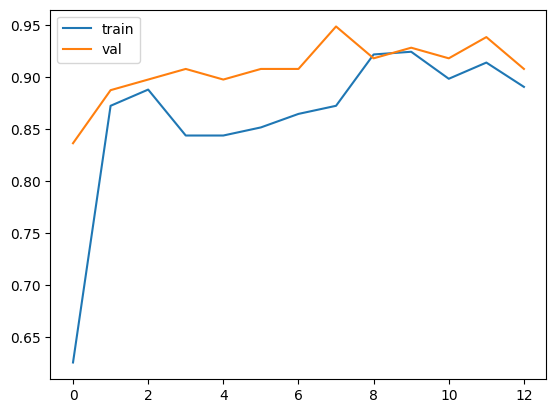

In [40]:
plt.plot(train_acc_hist, label= 'train')
plt.plot(val_acc_hist, label= 'val')
plt.legend()
plt.show()

plt.plot(train_loss_hist)
plt.show()

In [42]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image*(np.array(0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image

TypeError: array() takes from 1 to 2 positional arguments but 3 were given

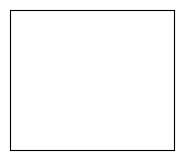

In [47]:
# 예측 결과 출력

classes = {0 : 'cat', 1 : 'dog'}

dataiter = iter(test_loader)
images, labels = next(iter(test_loader))
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize= (25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks= [], yticks= [])
    plt.imshow(im_convert(images[idx]))
    a.set_title(f'{classes[preds[idx].item]}({classes[labels[idx].item()]})', color= ('green' if preds[idx] == labels[idx] else 'red'))

plt.show()
plt.subplots_adjust(bottom= 0.2, top= 0.6, hspace= 0)